# Imports

In [37]:
from sklearn.datasets import make_moons
from sklearn.utils import Bunch
import torch as th
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
import pandas as pd
import json

# Parameters / Magic Numbers

In [38]:
SEED = 0
FEATURE_IMPORTANCE_SEED = 0
FEATURE_IMPORTANCE_N_REPEATS = 30
NUM_SAMPLES = 300
NOISE = 0.05
NUM_EPOCHS = 1000
TRAIN_TEST_SPLIT_RATIO = 0.8
LEARNING_RATE = 4e-3
RESOLUTION = 20
HIDDEN_DIM = 32
NUM_LAYERS = 4
TQDM_NCOLS = 150
TQDM_UPDATE_FREQUENCY = 10


# NAMs in PyTorch

In [39]:
from contextlib import contextmanager

def class_specific_error(output, y, target_class):
    if output.shape[1] == 1:  # Binary classification case
        y_binary = (y == target_class).type(th.float32)
        errors = np.abs((output.squeeze() - y_binary).detach().numpy())
    else:  # Multi-class classification case
        errors = (output[np.arange(len(y)), y] != output[np.arange(len(y)), target_class]).float()
    return errors.mean().item()

def overall_error(output, y):
    if output.shape[1] == 1:
        y_binary = (y == 1).type(th.float32)
        errors = np.abs((output.squeeze() - y_binary).detach().numpy())
    else:
        errors = (output[np.arange(len(y)), y] != output[np.arange(len(y)), output.argmax(dim=1)]).float()
    return errors.mean().item()


# define the Neural Additive Model for 2D inputs only without the 1D submodules
class NAM2DOnly(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(NAM2DOnly, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        
        # initialize the 2D submodules
        for i, j in combinations(range(input_dim), 2):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim, input_size=2)
            self.submodules.append(submodule)
    
    # TODO make the submodule architecture a parameter
    def create_submodule(self, num_layers, hidden_dim, output_dim, input_size=1):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(input_size, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
            # TODO make this optional as a parameter
            submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
        return submodule

    def forward(self, x):
        output = th.zeros(x.shape[0], self.output_dim)
        
        # process 2D submodules
        submodule_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            output += self.submodules[submodule_idx](x[:, [i, j]])
            submodule_idx += 1

        return th.nn.functional.softmax(output, dim=1)
    
    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize output tensors
        output_2D = th.zeros(self.input_dim * (self.input_dim - 1) // 2, resolution, resolution, self.output_dim)

        # process 2D submodules
        submodule_idx = 0
        pair_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            for k in range(resolution):
                for l in range(resolution):
                    input_values = th.tensor([[k / (resolution - 1), l / (resolution - 1)]]).float()
                    output_2D[pair_idx, k, l] = self.submodules[submodule_idx](input_values)
            pair_idx += 1
            submodule_idx += 1

        # return output as numpy arrays
        return output_2D.detach().numpy()



# define the Neural Additive Model
class NAM2D1D(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(NAM2D1D, self).__init__()
        if output_dim == 2:
            output_dim = 1
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        
        # initialize the 1D submodules
        for i in range(input_dim):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim)
            self.submodules.append(submodule)

        # initialize the 2D submodules
        for i, j in combinations(range(input_dim), 2):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim, input_size=2)
            self.submodules.append(submodule)
    
    # TODO make the submodule architecture a parameter
    def create_submodule(self, num_layers, hidden_dim, output_dim, input_size=1):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(input_size, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
            # TODO make this optional as a parameter
            # submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
        return submodule

    def forward(self, x):
        output = th.zeros(x.shape[0], self.output_dim)
        
        # process 1D submodules
        for i in range(self.input_dim):
            output += self.submodules[i](x[:, i].unsqueeze(1))
        
        # process 2D submodules
        submodule_idx = self.input_dim
        for i, j in combinations(range(self.input_dim), 2):
            output += self.submodules[submodule_idx](x[:, [i, j]])
            submodule_idx += 1

        if self.output_dim == 1:
            return th.nn.functional.sigmoid(output)
        # else:
        #     return th.nn.functional.softmax(output, dim=1)
        return output

    
    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    @contextmanager
    def _eval_mode(self):
        was_training = self.training
        self.eval()
        try:
            yield
        finally:
            if was_training:
                self.train()

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize output tensors
        output_1D = th.zeros(self.input_dim, resolution, self.output_dim)
        output_2D = th.zeros(self.input_dim * (self.input_dim - 1) // 2, resolution, resolution, self.output_dim)

        # process 1D submodules
        for i in range(self.input_dim):
            for j in range(resolution):
                input_value = th.tensor([[j / (resolution - 1)]]).float()
                output_1D[i, j] = self.submodules[i](input_value)

        # process 2D submodules
        submodule_idx = self.input_dim
        pair_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            for k in range(resolution):
                for l in range(resolution):
                    input_values = th.tensor([[k / (resolution - 1), l / (resolution - 1)]]).float()
                    output_2D[pair_idx, k, l] = self.submodules[submodule_idx](input_values)
            pair_idx += 1
            submodule_idx += 1

        # return output as numpy arrays
        return output_1D.detach().numpy(), output_2D.detach().numpy()

    
    def permuted_forward_pass_2D(self, X, i, j, random_state=0):
        """
        Same as forward pass but when the submodule which processes the pair (i, j) is called, the data is permuted at the features i and j using the random_state.
        When the 1D submodules are called that process either i or j, the data is not permuted!

        Parameters:
            X: input data
            i: the first feature (the combination with j is permuted)
            j: the second feature (the combination with i is permuted)
            random_state: the seed to use for the permutation

        returns:
            the output of the network
        """
        output = th.zeros(X.shape[0], self.output_dim)

        # process 1D submodules
        for k in range(self.input_dim):
            output += self.submodules[k](X[:, k].unsqueeze(1))

        # process 2D submodules
        submodule_idx = self.input_dim
        rng = th.Generator().manual_seed(random_state)
        X_permuted = X.clone()
        X_permuted[:, [i, j]] = X_permuted[:, [i, j]][th.randperm(X.shape[0], generator=rng)]
        
        for idx, (k, l) in enumerate(combinations(range(self.input_dim), 2)):
            if k == i and l == j:
                output += self.submodules[submodule_idx + idx](X_permuted[:, [i, j]])
            else:
                output += self.submodules[submodule_idx + idx](X[:, [k, l]])

        return th.nn.functional.softmax(output, dim=1)
    
    def get_importance_2D(self, X, y, i, j, target_class, n_repeats=30, random_state=0):
        """
        Return the importance of the 2D submodule for the pair (i, j) for the target_class.
        The forward pass is called without permutation on the dataset first.
        Then we call a forward pass with permutation on the dataset where when the part of the architecture is called where features i and j are processed, the data is permuted.
        We take the ratio of original error / permuted error and repeat the cycle n_repeats times to average the importance.

        Parameters:
            X: input data
            y: labels
            i: the first feature (the combination with j is permuted)
            j: the second feature (the combination with i is permuted)
            target_class: the class for which we want to compute the importance
            n_repeats: the number of times to repeat the permutation
            random_state: the seed to use for the permutation

        returns:
            The importance of the 2D submodule for the pair (i, j)
        """
        with self._eval_mode():
            original_output = self.forward(X)
            if target_class is not None:
                original_error = class_specific_error(original_output, y, target_class)
            else:
                original_error = overall_error(original_output, y)

            # Use a small safety value if the original_error is zero
            if original_error == 0:
                original_error = 1e-5

            permuted_errors = []
            for r in range(n_repeats):
                permuted_output = self.permuted_forward_pass_2D(X, i, j, random_state + r)
                if target_class is not None:
                    permuted_error = class_specific_error(permuted_output, y, target_class)
                else:
                    permuted_error = overall_error(permuted_output, y)
                permuted_errors.append(permuted_error)

            return np.mean(permuted_errors) / original_error

    def permuted_forward_pass_1D(self, X, i, random_state=0):
        """
        Same as forward pass but when the submodule which processes the feature i is called, the data is permuted at the feature i using the random_state.

        Parameters:
            X: input data
            i: the feature (i is permuted)
            random_state: the seed to use for the permutation

        returns:
            the output of the network
        """
        output = th.zeros(X.shape[0], self.output_dim)

        rng = th.Generator().manual_seed(random_state)
        X_permuted = X.clone()
        X_permuted[:, i] = X_permuted[:, i][th.randperm(X.shape[0], generator=rng)]

        # process 1D submodules
        for k in range(self.input_dim):
            if k == i:
                output += self.submodules[k](X_permuted[:, k].unsqueeze(1))
            else:
                output += self.submodules[k](X[:, k].unsqueeze(1))

        # process 2D submodules
        submodule_idx = self.input_dim
        for idx, (k, l) in enumerate(combinations(range(self.input_dim), 2)):
            output += self.submodules[submodule_idx + idx](X[:, [k, l]])

        return th.nn.functional.softmax(output, dim=1)

    def get_importance_1D(self, X, y, i, target_class, n_repeats=30, random_state=0):
        """
        Return the importance of the 1D submodule for the feature i for the target_class.
        The forward pass is called without permutation on the dataset first.
        Then we call a forward pass with permutation on the dataset where when the part of the architecture is called where feature i is processed, the data is permuted.
        We take the ratio of original error / permuted error and repeat the cycle n_repeats times to average the importance.

        Parameters:
            X: input data
            y: labels
            i: the feature (i is permuted)
            target_class: the class for which we want to compute the importance
            n_repeats: the number of times to repeat the permutation
            random_state: the seed to use for the permutation

        returns:
            The importance of the 1D submodule for the feature i
        """
        with self._eval_mode():
            original_output = self.forward(X)
            if target_class is not None:
                original_error = class_specific_error(original_output, y, target_class)
            else:
                original_error = overall_error(original_output, y)

            # Use a small safety value if the original_error is zero
                if original_error == 0:
                    original_error = 1e-5

            permuted_errors = []
            for r in range(n_repeats):
                permuted_output = self.permuted_forward_pass_1D(X, i, random_state + r)
                if target_class is not None:
                    permuted_error = class_specific_error(permuted_output, y, target_class)
                else:
                    permuted_error = overall_error(permuted_output, y)
                permuted_errors.append(permuted_error)

            return np.mean(permuted_errors) / original_error



# define the Neural Additive Model
class NAM(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        # for each input dimension, we have an individual network with num_layers layers
        # the output of the overall network is the sum of the outputs of the individual networks, fed into a softmax for classification
        super(NAM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        # initialize the submodules and make sure they accept input dimension = 1 for the first layer and hidden_dim for all other layers. they should have num_layers layers and output_dim output dimensions
        # also use dropout with p=0.5
        for i in range(input_dim):
            # initialize the submodule
            submodule = th.nn.Sequential()
            for l in range(num_layers):
                if l == 0:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
                else:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
                submodule.add_module(f"ELU_{l}", th.nn.ELU())
                submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
            # each subnetwork has a final linear layer to output the final output
            submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
            # add the submodule to the list of submodules
            self.submodules.append(submodule)
                        
    
    def forward(self, x):
        """
        The forward pass passes each input dimension through the corresponding submodule and sums over their outputs. The output is then fed into a softmax for classification.
        """
        # initialize the output
        output = th.zeros(x.shape[0], self.output_dim)
        # for each input dimension, pass it through the corresponding submodule and add the output to the overall output
        for i in range(self.input_dim):
            output += self.submodules[i](x[:,i].unsqueeze(1))
        # return the softmax of the output
        return th.nn.functional.softmax(output, dim=1)

    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize the output
        output = th.zeros(resolution, self.input_dim, self.output_dim)
        # for each input dimension, pass it through the corresponding submodule and add the output to the overall output
        for i in range(self.input_dim):
            for j in range(resolution):
                output[j,i] = self.submodules[i](th.tensor([[j/resolution]]))
        # return output as numpy array
        return np.moveaxis(output.detach().numpy(), 0, -1)

# Function Definitions

In [40]:
def create_sklearn_dataset(X, y, feature_names, target_names):
    return Bunch(data=X,
                 target=y,
                 feature_names=feature_names,
                 target_names=target_names)


def normalize_data(X):
    original_min = X.min(axis=0)
    original_max = X.max(axis=0)
    X_normalized = (X - original_min) / (original_max - original_min)
    return X_normalized, original_min, original_max


def train(model, X, y, optimizer, loss_fn, is_binary):
    model.train()
    X = th.tensor(X, dtype=th.float32)
    if is_binary:
        y = th.tensor(y, dtype=th.float32).view(-1, 1)
    else:
        y = th.tensor(y, dtype=th.long)
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, X, y, loss_fn, is_binary):
    model.eval()
    X = th.tensor(X, dtype=th.float32)
    if is_binary:
        y = th.tensor(y, dtype=th.float32).view(-1, 1)
    else:
        y = th.tensor(y, dtype=th.long)
    output = model(X)
    loss = loss_fn(output, y)
    if is_binary:
        accuracy = ((output > 0.5).type(th.float32) == y).sum().item() / y.shape[0]
    else:
        accuracy = (output.argmax(dim=1) == y).sum().item() / y.shape[0]
    return loss.item(), accuracy

def revert_normalization(feature_maps, data_min, data_range):
    for i in range(feature_maps.shape[-1]):
        feature_maps[..., i] = feature_maps[..., i] * data_range[i] + data_min[i]
    return feature_maps


# Data

### Loading the Data

In [41]:
# iris from sklearn
from sklearn.datasets import load_iris
sklearn_dataset = iris = load_iris()
X = iris.data
y = iris.target
# list from ndarray
feature_names = iris.feature_names
num_features = len(feature_names)
target_names = iris.target_names.tolist()
output_dim = len(target_names)

# X, y = make_moons(n_samples=NUM_SAMPLES, noise=NOISE, random_state=SEED)
# # TODO remove, this is just to test normalization and reversal of normalization
# X *= 5
# num_features = X.shape[1]
# output_dim = len(np.unique(y))
# input_ranges = np.zeros((num_features, 2))
# for i in range(num_features):
#     input_ranges[i, 0] = np.min(X[:, i])
#     input_ranges[i, 1] = np.max(X[:, i])

# feature_names = ['x', 'y']
# target_names = ['Class_0', 'Class_1']

# sklearn_dataset = create_sklearn_dataset(X, y, feature_names, target_names)


### Plotting the Data

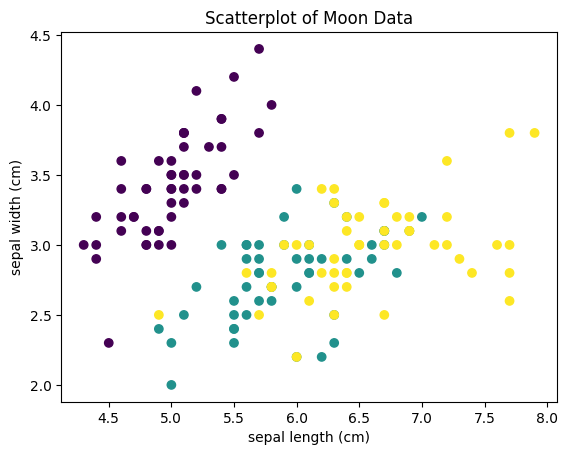

In [42]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Scatterplot of Moon Data')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()


### Preprocessing

In [43]:
X, original_min, original_max = normalize_data(X)

output_class_dict = {i: sklearn_dataset.target_names[i] for i in range(len(sklearn_dataset.target_names))}
feature_dict = {i: sklearn_dataset.feature_names[i] for i in range(len(sklearn_dataset.feature_names))}

train_size = int(TRAIN_TEST_SPLIT_RATIO * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]


# Model Definition and Training

In [44]:
from tqdm import tqdm

unique_labels = len(np.unique(y_train))
if unique_labels == 2:
    output_dim = 1
    loss_fn = th.nn.BCELoss()
    is_binary = True
else:
    output_dim = unique_labels
    loss_fn = F.cross_entropy
    is_binary = False

model = NAM2D1D(input_dim=num_features, hidden_dim=HIDDEN_DIM, output_dim=output_dim, num_layers=NUM_LAYERS)

th.manual_seed(SEED)
np.random.seed(SEED)
model.apply(model.init_weights)

# print(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Create a tqdm progress bar
progress_bar = tqdm(range(NUM_EPOCHS), desc="Training progress", ncols=TQDM_NCOLS)

for epoch in progress_bar:
    train_loss = train(model, X_train, y_train, optimizer, loss_fn, is_binary=is_binary)
    test_loss, test_accuracy = evaluate(model, X_test, y_test, loss_fn, is_binary=is_binary)
    
    # Update the progress bar description less frequently (every update_frequency epochs)
    if epoch % TQDM_UPDATE_FREQUENCY == 0:
        progress_bar.set_description(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, test loss = {test_loss:.4f}, test accuracy = {test_accuracy:.4f}')

print(f'Final test accuracy: {test_accuracy:.4f}')


Epoch 991: train loss = 0.0000, test loss = 1.6410, test accuracy = 0.8333: 100%|█████████████████████████████████| 1000/1000 [00:18<00:00, 53.50it/s]

Final test accuracy: 0.8333


### Storing Data with Predictions

In [45]:
# Revert the normalization
X_reverted = X * (original_max - original_min) + original_min

# Convert the input data to PyTorch tensor
X_tensor = th.tensor(X, dtype=th.float32)

# Get the model predictions
with th.no_grad():
    model.eval()
    predictions = model(X_tensor)

    # Check if it's a binary classification case
    if len(target_names) == 2:
        pred_classes = (predictions > 0.5).numpy().astype(int)[:, 0]
    else:
        pred_classes = th.argmax(predictions, dim=1).numpy()

# Create a Pandas DataFrame with the reverted data, target labels, and predictions
data_frame = pd.DataFrame(X_reverted, columns=feature_names)
data_frame['target'] = y
data_frame['predictions'] = pred_classes
target_name_mapping = {i: target_names[i] for i in range(len(target_names))}

# Save the DataFrame as a CSV file
data_frame.to_csv('dataset_with_predictions.csv', index=False)

### Calculating Feature Importances

In [46]:
# get_importance_2D(self, X, y, i, j, n_repeats, random_state) and get_importance_1D(self, X, y, i, n_repeats, random_state)
# calculate the feature importance for each 1D feature and each 2D feature combination and create a list of scores

# TODO this is being called for unique_classes - and why does this even work in the binary classification case when there should only be 1 set of submodules

# Get the unique classes in the target variable (y) and create a dictionary to map class index to class name
unique_classes = np.unique(y)
class_index_to_name = {index: name for index, name in enumerate(target_names)}

X_tensor = th.tensor(X).float()
y_tensor = th.tensor(y).long()

if len(unique_classes) > 2:  # Multi-class case
    one_d_importances = {class_index_to_name[c]: [] for c in unique_classes}
    for c in unique_classes:
        for i in range(num_features):
            importance = model.get_importance_1D(X_tensor, y_tensor, i, c, FEATURE_IMPORTANCE_N_REPEATS, FEATURE_IMPORTANCE_SEED)
            one_d_importances[class_index_to_name[c]].append(importance)

    two_d_importances = {class_index_to_name[c]: [] for c in unique_classes}
    for c in unique_classes:
        for i, j in combinations(range(num_features), 2):
            importance = model.get_importance_2D(X_tensor, y_tensor, i, j, c, FEATURE_IMPORTANCE_N_REPEATS, FEATURE_IMPORTANCE_SEED)
            two_d_importances[class_index_to_name[c]].append(importance)
else:  # Binary classification case
    one_d_importances = []
    for i in range(num_features):
        importance = model.get_importance_1D(X_tensor, y_tensor, i, None, FEATURE_IMPORTANCE_N_REPEATS, FEATURE_IMPORTANCE_SEED)
        one_d_importances.append(importance)

    two_d_importances = []
    for i, j in combinations(range(num_features), 2):
        importance = model.get_importance_2D(X_tensor, y_tensor, i, j, None, FEATURE_IMPORTANCE_N_REPEATS, FEATURE_IMPORTANCE_SEED)
        two_d_importances.append(importance)

feature_importance_scores = {
    "1D": one_d_importances,
    "2D": two_d_importances
}

print("Feature Importance Scores:", feature_importance_scores)

Feature Importance Scores: {'1D': {'setosa': [1.0, 1.0, 1.0, 1.0], 'versicolor': [1.0, 1.0, 1.0, 1.0], 'virginica': [1.0, 1.0, 1.0, 1.0]}, '2D': {'setosa': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'versicolor': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'virginica': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}


### Storing Feature Maps

In [47]:
def feature_maps_to_json(output_1D, output_2D, feature_names, target_names, importance_scores, resolution=100):
    feature_maps_dict = {"1D": {}, "2D": {}}

    is_binary_classification = len(target_names) == 2
    class_names = target_names if not is_binary_classification else [target_names[0]]

    # Store 1D feature maps
    for i in range(output_1D.shape[0]):
        for j, target_name in enumerate(class_names):
            key_suffix = f"{i}" if is_binary_classification else f"{i}_{target_name}"
            feature_maps_dict["1D"][f"feature_map_{key_suffix}"] = {
                "feature": feature_names[i],
                "class": None if is_binary_classification else target_name,
                "classIndex": None if is_binary_classification else target_names.index(target_name),
                "importance": importance_scores["1D"][i] if is_binary_classification else importance_scores["1D"][target_name][i],
                "data": output_1D[i, :, j].tolist()
            }

    # Store 2D feature maps
    pair_idx = 0
    for i, j in combinations(range(output_1D.shape[0]), 2):
        for k, target_name in enumerate(class_names):
            key_suffix = f"{i}_{j}" if is_binary_classification else f"{i}_{j}_{target_name}"
            feature_maps_dict["2D"][f"feature_map_{key_suffix}"] = {
                "feature_1": feature_names[i],
                "feature_2": feature_names[j],
                "class": None if is_binary_classification else target_name,
                "classIndex": None if is_binary_classification else target_names.index(target_name),
                "importance": importance_scores["2D"][pair_idx] if is_binary_classification else importance_scores["2D"][target_name][pair_idx],
                "data": output_2D[pair_idx, :, :, k].tolist()
            }
        pair_idx += 1

    return feature_maps_dict



# Get feature maps
output_1D, output_2D = model.get_feature_maps(RESOLUTION)

# Convert feature maps to JSON format
feature_maps_json = feature_maps_to_json(output_1D, output_2D, feature_names, target_names, feature_importance_scores, RESOLUTION)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

# Save feature maps to a JSON file
with open("feature_maps.json", "w") as f:
    json.dump(feature_maps_json, f, ensure_ascii=False, indent=4, cls=NumpyEncoder)


# Feature Maps and Visualization

In [48]:
# feature_maps_1D, feature_maps_2D = model.get_feature_maps(resolution=RESOLUTION)

# data_min = X.min(axis=0)
# data_range = X.max(axis=0) - data_min

# # feature_maps_1D = revert_normalization(feature_maps_1D, data_min, data_range)
# # feature_maps_2D = revert_normalization(feature_maps_2D, data_min, data_range)

# num_pairs, _, _, num_classes = feature_maps_2D.shape
# pair_indices = list(combinations(range(num_features), 2))

# fig, axs = plt.subplots(num_pairs, num_classes, figsize=(12, 4 * num_pairs), squeeze=False)
# for pair_idx, (i, j) in enumerate(pair_indices):
#     for output_feature in range(num_classes):
#         x = np.linspace(input_ranges[i, 0], input_ranges[i, 1], RESOLUTION)
#         y = np.linspace(input_ranges[j, 0], input_ranges[j, 1], RESOLUTION)
#         X, Y = np.meshgrid(x, y)
#         Z = feature_maps_2D[pair_idx, :, :, output_feature].T

#         target_class = output_feature
#         im = axs[pair_idx, output_feature].contourf(X, Y, Z, cmap='viridis', levels=20)
#         axs[pair_idx, output_feature].scatter(X_test[:, i], X_test[:, j], c=y_test, alpha=0.5, cmap='viridis')
#         axs[pair_idx, output_feature].set_title(f'{feature_dict[i]} and {feature_dict[j]} for {output_class_dict[output_feature]}')

#         axs[pair_idx, output_feature].set_xlabel(feature_dict[i])
#         axs[pair_idx, output_feature].set_ylabel(feature_dict[j])

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.6)
# plt.show()
